In [1]:
import numpy as np
import pandas as pd
from scipy.signal import fftconvolve, gaussian
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from lab3.experiment.base import ImagingExperiment, fetch_trials
from lab3.experiment.virtual import VirtualImagingExperiment
from lab3.misc.progressbar import ProgressBar

sns.set(style='ticks', context='talk')

In [2]:
trial_ids = fetch_trials(project_name='james', mouse_name='jbp_vr_006', experimentType='historyDependence')

In [3]:
expt = VirtualImagingExperiment(trial_ids[1]) #21971)

In [4]:
# get behavior data synchronized to the imaging data
beh_data = expt.format_behavior_data()
laps = beh_data['lap_bin']

# discretize position
n_position_bins = 100
pos = (beh_data['treadmillPosition'] * n_position_bins).astype('int')

# binarize spikes
spikes = expt.signals(label='suite2p', signal_type='spikes')
spikes = np.greater(spikes, 0)

spikes = spikes.iloc[:, expt.valid_samples()]
laps = laps[expt.valid_samples()]
pos = pos[expt.valid_samples()]

In [72]:
columns = pd.MultiIndex.from_arrays([laps, pos, spikes.columns], names=['lap_number', 'position', 'time'])

In [77]:
testing = pd.DataFrame(spikes.values, columns=idx, index=pd.Index(spikes.index, name='roi_label'))

In [100]:
start = time.time()
[pd.DataFrame(testing.iloc[i]).pivot_table(index='lap_number', columns='position') for i in range(1000)]
print(time.time() - start)

14.164539575576782


In [97]:
.02 * 4000

80.0

In [62]:
start = time.time()
testing2 = testing.groupby(['lap_number', 'position']).mean()
print(time.time() - start)

1.699228048324585


In [60]:
testing.pivot_table(index=['roi_label', 'lap_number'], columns='position', fill_value=0)

KeyError: 'roi_label'

In [5]:
def get_raster_df(spikes, laps, pos):
    """"""
    
    pos_idx = pd.Index(np.unique(pos), name='position')
    lap_idx = pd.Index(np.unique(laps), name='laps')
    
    rasters = np.zeros((len(pos_idx), len(lap_idx), len(spikes.index)))
    for p in pos_idx:
        rasters[p] = np.vstack([np.mean(
            spikes.iloc[:, (laps==l) & (pos==p)], axis=1) 
                                for l in lap_idx])
    
    rasters = [pd.DataFrame(r, index=lap_idx, columns=pos_idx) for r in rasters.T]
    return pd.concat(rasters, keys=pd.Index(spikes.index, name='roi_label')).fillna(0)
        
#     rasters = np.stack([np.vstack([np.mean(spikes.iloc[:, (laps==l) & (pos==p)], axis=1) 
#                                    for l in lap_idx]) for p in pos_idx]).T
    
#     return rasters
#     return pd.concat([pd.DataFrame(r, index=lap_idx, columns=pos_idx) for r in rasters],
#                      keys=pd.Index(spikes.index, name='roi_label')).fillna(0)
    

In [35]:
import time
start = time.time()
testing = get_raster_df(spikes.iloc[0:100], laps, pos)
print(time.time() - start)

16.232885599136353


In [36]:
from scipy.signal import convolve, gaussian
k = gaussian(8 * 2, 2)
k /= k.sum()

In [37]:
for t in range(10):
    start = time.time()

    testing.iloc[:, :] = np.apply_along_axis(
        convolve, 1, testing, k, mode='same')

    print(time.time() - start)

0.5642299652099609
0.560783863067627
0.560434103012085
0.556971549987793
0.5563559532165527
0.5566940307617188
0.5620739459991455


KeyboardInterrupt: 

In [18]:
from importlib import reload
from lab3.analysis.spatial.spatial_tuning import SimpleSpatialTuning

In [19]:
strategy = SimpleSpatialTuning(sigma=2)

In [20]:
start = time.time()

results = strategy.calculate(spikes.iloc[0:100], pos, laps)
shuffle = strategy.calculate(spikes.iloc[0:100], pos, laps, shuffle=True)

print(time.time() - start)

32.48506426811218


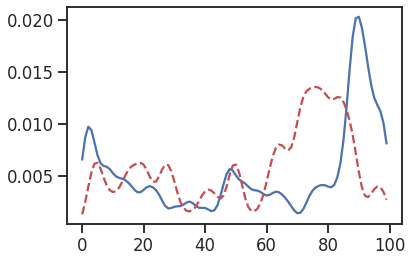

In [28]:
plt.figure()
plt.plot(results.groupby('roi_label').mean().iloc[91])
plt.plot(shuffle.groupby('roi_label').mean().iloc[91], color='r', linestyle='--')

In [ ]:
# 800 looks interesting...

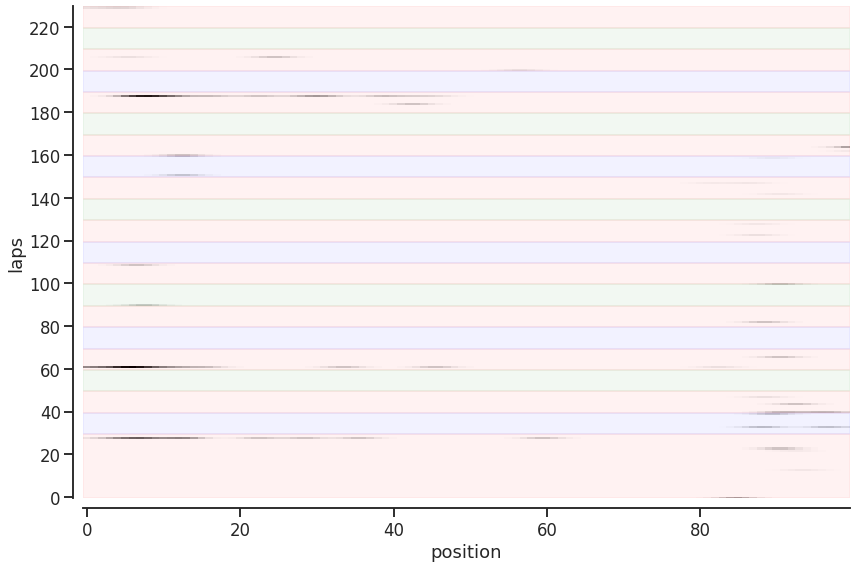

In [94]:
cumsum = 0
for _, raster in testing.groupby('roi_label'):
    
    cumsum += 1
    if cumsum == 909:
        break
        
plt.figure(figsize=(12, 8))
sns.heatmap(raster.reset_index(level=0, drop=True).rolling(
    window=10, win_type='gaussian', center=True, min_periods=2, axis=1).mean(std=2),
            cmap='Greys', xticklabels=20, yticklabels=20, cbar=False)

for start, stop in expt.behavior_data['__trial_info']['contexts']['ctxA']['decorators'][1]['lap_list']:
    plt.axhspan(start, stop, color='red', alpha=0.05)
for start, stop in expt.behavior_data['__trial_info']['contexts']['ctxB']['decorators'][1]['lap_list']:
    plt.axhspan(start, stop, color='blue', alpha=0.05)
for start, stop in expt.behavior_data['__trial_info']['contexts']['ctxC']['decorators'][1]['lap_list']:
    plt.axhspan(start, stop, color='green', alpha=0.05)
plt.ylim([0, 230])

sns.despine(offset=10)
plt.tight_layout()

In [ ]:
tuning = [testing.loc[pd.IndexSlice[:, start:(stop-1)], :].groupby('roi_label').mean().values.flatten()
          for start, stop in expt.behavior_data['__trial_info']['contexts']['ctxA']['decorators'][1]['lap_list'][1:]]

plt.figure()
sns.heatmap(np.corrcoef(np.stack(tuning)), square=True, vmax=0.25)

sns.despine()
plt.tight_layout()

In [95]:
laps

array([  0,   0,   0, ..., 229, 229, 230])

In [83]:
expt.behavior_data['__trial_info']['contexts']['ctxA']['decorators'][1]['lap_list']

[[0, 30],
 [40, 50],
 [60, 70],
 [80, 90],
 [100, 110],
 [120, 130],
 [140, 150],
 [160, 170],
 [180, 190],
 [200, 210],
 [220, 230]]

In [227]:

roi_index = pd.Index(df.index, name='roi_label')
testing_df = pd.concat([pd.DataFrame(x, index=pd.Index(np.arange(236), name='lap_number'),
                        columns=pd.Index(np.arange(100), name='position')) for x in testing],
                        keys=roi_index).fillna(0)

In [229]:
start = time.time()
testing = np.stack([np.vstack([spikes.iloc[:, (laps==l) & (pos==p)].mean(axis=1) for l in range(236)]) 
                    for p in range(100)])
print(time.time() - start)

47.728691816329956


In [231]:
testing.T.shape

(3771, 236, 100)

In [220]:
start = time.time()
testing = np.stack([np.vstack([spikes.iloc[:, (laps==l) & (pos==p)].mean(axis=1) for p in range(100)]) 
                    for l in range(236)])
print(time.time() - start)

17.114685773849487


In [226]:
testing = np.moveaxis(testing, -1, 0)

In [136]:
roi_index = pd.Index(df.index, name='roi_label')
testing_df = pd.concat([pd.DataFrame(x, index=pd.Index(np.arange(236), name='lap_number'),
                        columns=pd.Index(np.arange(100), name='position')) for x in testing],
                        keys=roi_index).fillna(0)

In [197]:
for count, (label, raster) in enumerate(testing_df.groupby('roi_label')):
    
    if count==3000:
        break

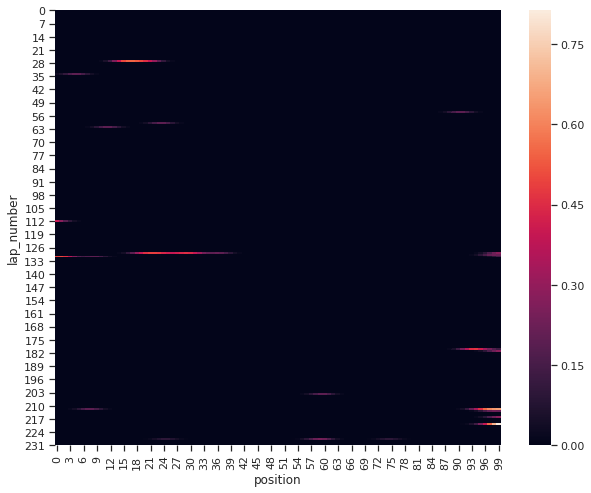

In [198]:
plt.figure(figsize=(10, 8))
sns.heatmap(raster.reset_index(level=0, drop=True).rolling(
    window=10, win_type='gaussian', center=True, min_periods=2, axis=1).mean(std=2))

In [ ]:
column_index = pd.MultiIndex.from_arrays([np.arange(spikes.shape[1]), pos, laps], 
                                         names=['time', 'position', 'lap_number'])
df = pd.DataFrame(spikes.values, index=spikes.index, columns=column_index)
start = time.time()
pd.DataFrame(series).pivot_table(index=['lap_number'], columns=['position']).fillna(0).
print(time.time() - start)

In [10]:
c, t = np.nonzero(testing.values)
new_testing = pd.DataFrame({'roi_label': testing.index[c], 
                            #'time': t, 
                            'pos': pd.Categorical(pos[t]), 
                            'lap': pd.Categorical(laps[t])})
new_testing['value'] = 1

In [11]:
import time
start = time.time()
out = new_testing.groupby(['roi_label', 'lap', 'pos']).agg('mean').unstack(level='pos').fillna(0)
print(time.time() - start)

KeyboardInterrupt: 

In [15]:
pd.crosstab(index=[new_testing.roi_label, new_testing.lap], columns=new_testing.pos)

KeyboardInterrupt: 

In [224]:
testing.index.names = ['roi_label']

In [302]:
start = time.time()
testing.iloc[1000].groupby(['lap_number', 'position']).agg('mean').unstack(level='position').fillna(0)
print(time.time() - start)

0.01825571060180664


In [265]:
def test_func(s):
    return s.groupby(['lap_number', 'position']).agg('mean').unstack(level='position').fillna(0)

In [314]:
testing.iloc[0:10].groupby('roi_label').apply(test_func)

KeyError: 'lap_number'

In [288]:
start = time.time()
testing2 = pd.concat({label: test_func(row) 
                      for label, row in testing.iloc[0:1000].iterrows()})
print(time.time() - start)

51.54671239852905


In [274]:
testing.iloc[0:10].groupby('roi_label').apply(test_func)

KeyError: 'lap_number'

In [ ]:
s.groupby(['lap_number', 'position']).agg('mean').unstack(level='position').fillna(0)

64.0

In [260]:
start = time.time()
long_testing = testing.reset_index().melt(id_vars='roi_label')
results = long_testing.groupby(
    ['roi_label', 'lap_number', 'position']).agg('mean').unstack(level='position').fillna(0)
stop = time.time()
print(stop - start)

KeyboardInterrupt: 

       roi_label     
value  0000-0006-0292    0.000972
       0000-0006-0394    0.001020
       0000-0007-0182    0.001214
       0000-0007-0296    0.000486
       0000-0007-0308    0.002818
       0000-0008-0230    0.003741
       0000-0008-0250    0.008307
       0000-0008-0257    0.003109
       0000-0008-0269    0.005829
       0000-0008-0352    0.003643
       0000-0008-0384    0.005975
       0000-0009-0316    0.002720
       0000-0009-0331    0.002963
       0000-0009-0344    0.000972
       0000-0009-0414    0.001943
       0000-0010-0194    0.000583
       0000-0010-0237    0.003838
       0000-0010-0363    0.001214
       0000-0010-0451    0.002040
       0000-0011-0244    0.001797
       0000-0011-0281    0.004809
       0000-0011-0375    0.001214
       0000-0012-0230    0.002332
       0000-0012-0271    0.002429
       0000-0012-0292    0.001846
       0000-0012-0304    0.000826
       0000-0012-0321    0.003303
       0000-0012-0350    0.002186
       0000-0012-0398    0

In [144]:
def make_tuning_curve(cell, pos, laps):
    pd.DataFrame([[cell.iloc[:, (pos==p) & (laps==l)].mean() for p in range(100)] for l in np.unique(laps)],
                 keys=np.unique(laps)

SyntaxError: Generator expression must be parenthesized if not sole argument (<ipython-input-144-dc066d45e9c2>, line 2)

In [ ]:
make_tuning_curve()

In [143]:
pd.concat([spikes.iloc[:, (laps==0) & (pos==p)].mean(axis=1) for p in range(100)], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0000-0447-0221,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
0000-0365-0178,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
0000-0318-0271,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
0000-0470-0229,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
0000-0348-0182,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
0000-0380-0224,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
0000-0380-0248,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
0000-0365-0234,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
0000-0334-0312,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
0000-0426-0269,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [135]:
testing = pd.concat([pd.concat([spikes.iloc[:, (pos==p) & (laps==l)].mean(axis=1) for l in np.unique(laps)], 
                     axis=0, keys=np.unique(laps), names=['lap', 'roi']).reorder_levels(['roi', 'lap']) 
                     for p in range(2)], axis=1) 

In [136]:
testing = pd.concat([pd.concat([spikes.iloc[:, (pos==p) & (laps==l)].mean(axis=1) for p in np.unique(pos)], 
                     axis=1, keys=np.unique(pos), names=['lap', 'roi']).reorder_levels(['roi', 'lap']) 
                     for p in range(2)], axis=1) 

,,0
roi,lap,
0000-0447-0221,0,0.000000
0000-0365-0178,0,0.000000
0000-0318-0271,0,0.000000
0000-0470-0229,0,0.000000
0000-0348-0182,0,0.000000
0000-0380-0224,0,0.000000
0000-0380-0248,0,0.000000
0000-0365-0234,0,0.000000
0000-0334-0312,0,0.000000


In [107]:
test = pd.concat([make_tuning_curve(spikes.iloc[:, laps==l], pos[laps==l]) for l in np.unique(laps)], 
                 axis=0, keys=np.unique(laps), names=['lap_number', 'roi_label'])

test = test.reorder_levels(['roi_label', 'lap_number']).sort_index(level='roi_label')
test = test.fillna(0)

KeyboardInterrupt: 

In [ ]:
from scipy.signal import fftconvolve, gaussian
kernel = gaussian(20, 2)
kernel /= kernel.sum()

In [ ]:
smooth_test = test.apply(fftconvolve, axis=1, args=(kernel), mode='same')

In [82]:
smooth_test = test.rolling(window=20, center=True, win_type='gaussian', axis=1, min_periods=5).mean(std=2)

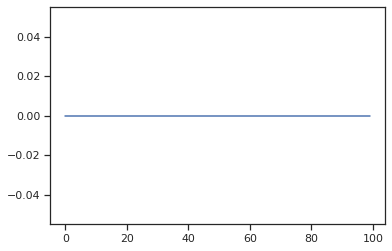

In [93]:
plt.figure()
plt.plot(smooth_test.groupby('roi_label').mean().iloc[6])

In [ ]:
smooth_test.groupby('roi_label')